# Librairies 

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.stats import norm
import plotly.graph_objs as go
#import plotly.graph_objects as go

# Définitions des fonctions

In [2]:
# Fonction modèle
def mod_vac_simp_nocomp(init,t, B, x , c, d, var, gamma0,vit1,kappa,p1,p2):

    S =init[0]
    I =init[1]
    vir =init[2]


    Sprime = B*(1-x) - d *S - transmission(vir,p1,p2) * S *I  +c*I
    Iprime = transmission(vir,p1,p2) * S *I - (d + c + vir)*I
    Virprime = var *(transmission(vir,p1,p2) * (S + gamma0 * I) - 1 ) 

    return(Sprime,Iprime,Virprime)



def mod_vac_simp_comp(init,t, B ,nik, c, d, var, gamma0,vit1,kappa,p1,p2):

    S =init[0]
    I =init[1]
    vir =init[2]
    x = init[3]
    

    Sprime = B*(1- x) - d *S  - beta(vir,p1,p2) * S *I  +c*I
    Iprime = beta(vir,p1,p2) * S *I - (d + vir)*I
    Virprime = var *(beta2(vir,p1,p2) * (S + gamma0 * I) - 1 ) 
    xprime = vit1 * x *(1 - x) * (I  - kappa)

    return(Sprime,Iprime,Virprime,xprime)




def mod_vac_simp_comp_noevo(init,t, B , c, d,vir,vit1,kappa,txtrans):

    S =init[0]
    I =init[1]
    x = init[2]
    

    Sprime = B*(1- x) - d *S  - txtrans* S *I +c*I
    Iprime = txtrans * S *I - (d + vir)*I
    xprime = vit1 * x *(1 - x) * ( I - kappa)

    return(Sprime,Iprime,xprime)


#Fonction de transmission

def mod_bauch(init,t, mu,beta,gamma,omega,kappa):

    S =init[0]
    I =init[1]
    x =init[2]


    Sprime = mu*(1 - x) - beta*S * I -mu*S
    Iprime = beta * S * I -gamma * I - mu*I
    Xprime = kappa*omega* x *(1 -x) *(  omega*I -1)

    return(Sprime,Iprime,Xprime)

### trade off croissant

def transmission(x,c, k ):
    return(c*x**k)
def transmission2(x,c, k ):
    return(c*k*x**(k-1))
def transmission3(x,c,k):
    return(c*k*(k-1)*x **(k-2))

### trade off saturant
def beta(x,c, k ):
    return((x*c)/(k+x))
def beta2(x,c, k ):
    return((c*k)/(k+x)**2)
def beta3(x,c,k):
    return(-((2*x + 2*k + k **2)*c*k /(x+k)**4))

## Simulations du modèle

#### Verification de la forme du trade-off

Text(0, 0.5, 'Transmission')

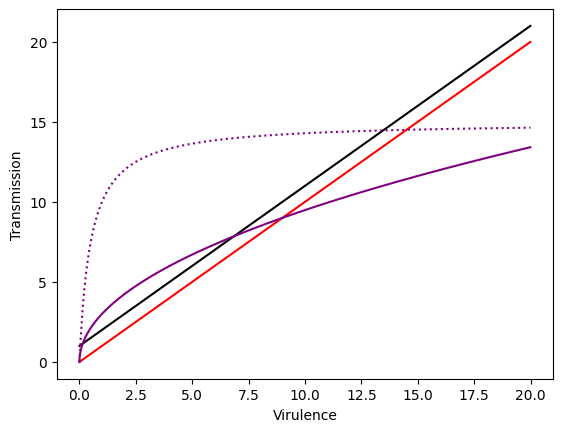

In [3]:
p1 = 3
p2 = 0.5


droite1 = np.zeros(2000)
droite2 = np.zeros(2000)
droite3 = np.zeros(2000)
droite4 = np.zeros(2000)
for y in range(2000):
    droite1[y] = y/100
    droite2[y] = 1+y/100
    droite3[y]=transmission(y/100,p1,p2)
    droite4[y]=beta(y/100,15,0.5)
figtrade, ax1 = plt.subplots()
ax1.plot(droite1,droite1,"red")
ax1.plot(droite1,droite2,"black")
ax1.plot(droite1,droite3,"purple")
ax1.plot(droite1,droite4,"purple",linestyle="dotted")
ax1.set_xlabel('Virulence')
ax1.set_ylabel('Transmission')


#### Paramètres

In [4]:
tmax =200
pas = 2000
nbr_pas = int(tmax/pas)
temps = np.linspace(0,tmax,pas)

#Paramètres démographiques
B = 1
x = 0.1
c = 0.0
d =  1

#Paramètres épi
var = 100
gamma0 = 0.1
vit1 = 100
kappa = 0.3

p1 =    15
p2 = 2.5

#Ci initiales
S0 = 0.9
I0 = 0.1
vir0 = 1.44
x0 = 0.5








### Simulation Avec et sans comp

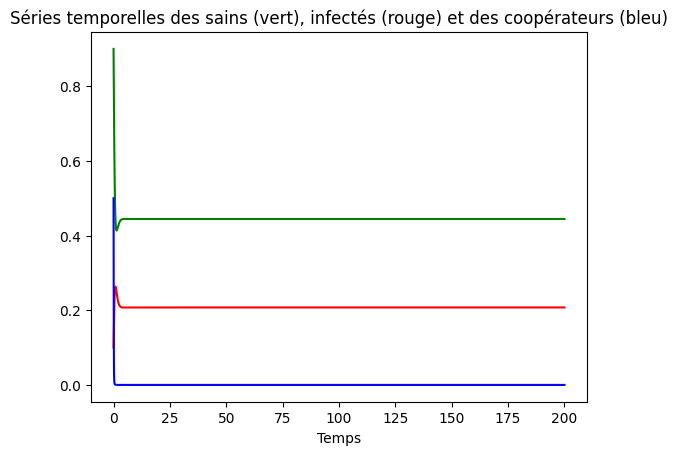

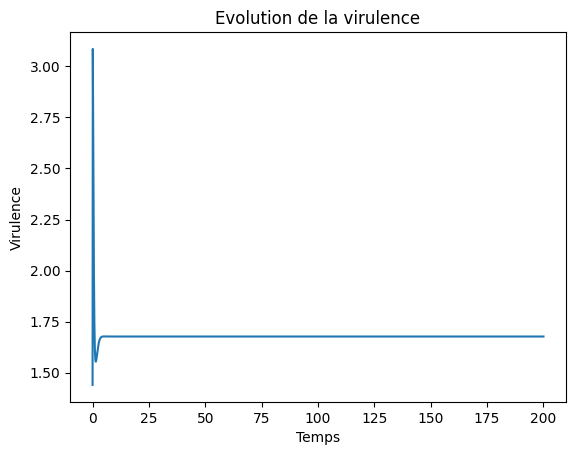

1.677023485954691


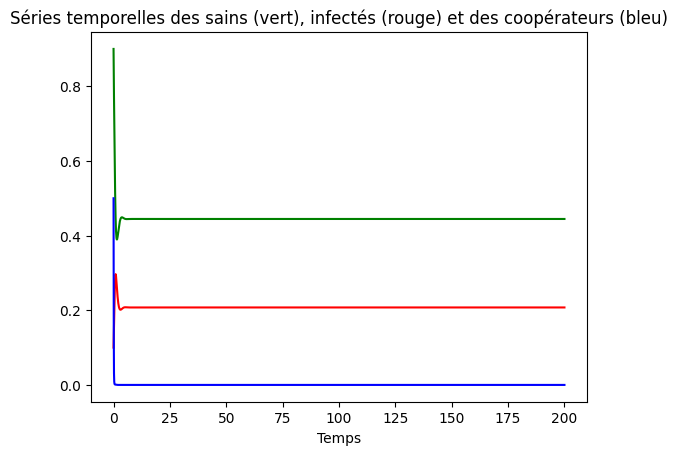

In [5]:
#Simulation du modèle
sol = odeint(mod_vac_simp_comp, y0 = [S0,I0,vir0,x0], t=temps,args = (B, x , c, d, var, gamma0,vit1,kappa,p1,p2))

#Affichage visuel
sns.lineplot(x = temps, y = sol[:,0],color = "green").set(title = "Séries temporelles des sains (vert), infectés (rouge) et des coopérateurs (bleu)",xlabel="Temps")
sns.lineplot(x = temps, y = sol[:,1],color = "red")
sns.lineplot(x = temps, y = sol[:,3],color = "blue")
plt.show()
sns.lineplot(x=temps, y=sol[:,2]).set(title = "Evolution de la virulence",xlabel="Temps",ylabel ="Virulence")
plt.show()


vir= np.mean(sol[pas-300:pas-1,2])
print(vir)
tx_trans = (vir*p1)/(vir+p2)



sol_noevo = odeint(mod_vac_simp_comp_noevo, y0 = [S0,I0,x0], t=temps,args = (B, c, d,vir,vit1,kappa,tx_trans))
sns.lineplot(x = temps, y = sol_noevo[:,0],color = "green").set(title = "Séries temporelles des sains (vert), infectés (rouge) et des coopérateurs (bleu)",xlabel="Temps")
sns.lineplot(x = temps, y = sol_noevo[:,1],color = "red")
sns.lineplot(x = temps, y = sol_noevo[:,2],color = "blue")
plt.show()



#### Comparaison d'avec et sans méthode de controle

1.4404939416980564


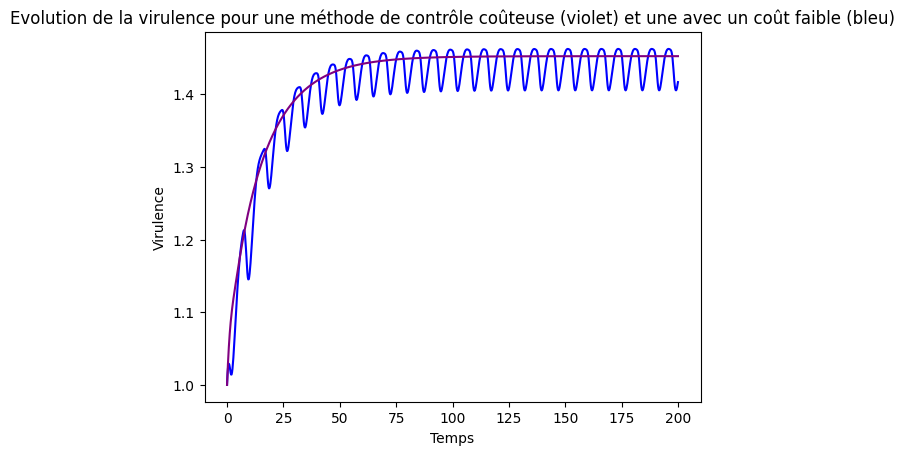

In [6]:
#Paramètres temps
tmax =200
pas = 1000
nbr_pas = int(tmax/pas)
temps = np.linspace(0,tmax,pas)

#Paramètres démographiques
B = 1
x = 0.1
c = 0.01
d =  1

#Paramètres épi
var = 0.1
gamma0 = 0.1
vit1 = 100
kappa = 0.1
kappa2 = 0.8
p1 =    9
p2 = 2

#Ci initiales
S0 = 0.9
I0 = 0.1
vir0 = 1
x0 = 0.5


#SImulation
sol = odeint(mod_vac_simp_comp, y0 = [S0,I0,vir0,x0], t=temps,args = (B, x , c, d, var, gamma0,vit1,kappa,p1,p2))
sol2 = odeint(mod_vac_simp_comp, y0 = [S0,I0,vir0,x0], t=temps,args = (B, x , c, d, var, gamma0,vit1,kappa2,p1,p2))

#Affichage graphique
sns.lineplot(x = temps, y = sol[:,2],color = "blue").set(title = "Evolution de la virulence pour une méthode de contrôle coûteuse (violet) et une avec un coût faible (bleu)",xlabel="Temps",ylabel = "Virulence")
sns.lineplot(x = temps, y = sol2[:,2],color = "purple")
print(np.mean(sol[900:999,2]))

## Diagramme de bifurcation


In [ ]:


tmax =500
pas = 5000
nbr_pas = int(tmax/pas)
temps = np.linspace(0,tmax,pas)

#Paramètres démographiques
B = 1
x = 0.1
c = 0.00
d =  1

#Paramètres épi
# var = 0.1
gamma0 = 0.1
vit1 = 50
kappa = 0.1
p1 =  11.5
p2 = 0.5

#Ci initiales
S0 = 0.9
I0 = 0.1
vir0 = 1.44
x0 = 0.5


#kappa et vit comp devient un vec
# lim_bas = [0.4,0.35,0.3,0.3,0.25,0.2,0.2,0.2,0.2,0.1]
# lim_haut = lim_bas + np.repeat(0.15,10)
tab_par1 = np.linspace(0.1, 10,2000)
#tab_par1 = np.linspace(0.001, 100,1000)

tabeq_haut_1 =np.zeros_like(tab_par1)
tabeq_bas_1 =np.zeros_like(tab_par1)

tabeq_haut_2 =np.zeros_like(tab_par1)
tabeq_bas_2 =np.zeros_like(tab_par1)

for i in range(len(tab_par1)):
    #vit1=tab_par1[i]
    var = tab_par1[i]
    sol = odeint(mod_vac_simp_comp, y0 = [S0,I0,vir0,x0], t=temps,args = (B, x , c, d, var, gamma0,vit1,kappa,p1,p2))
    smin=min(sol[pas-100:pas-1,1])
    smax=max(sol[pas-100:pas-1,1])

    tabeq_haut_1[i] = smin
    tabeq_bas_1[i] = smax


    vir= np.mean(sol[pas-100:pas-1,2])
    #txtrans=(p1*vir**p2)
    txtrans = (vir*p1)/(vir+p2) 
    sol2 = odeint(mod_vac_simp_comp_noevo, y0 = [S0,I0,x0], t=temps,args = (B,  c, d, vir,vit1,kappa,txtrans))
    smin2=min(sol2[pas-100:pas-1,1])
    smax2=max(sol2[pas-100:pas-1,1])


    tabeq_haut_2[i] = smin2
    tabeq_bas_2[i] = smax2


figtrade, ax1 = plt.subplots()
ax1.plot(tab_par1,tabeq_haut_1,color ="red")
ax1.plot(tab_par1,tabeq_bas_1,color ="blue")
ax1.plot(tab_par1,tabeq_haut_2,color ="red",linestyle="dotted")
ax1.plot(tab_par1,tabeq_bas_2,color ="blue",linestyle="dotted")
ax1.set_xlabel('Taux de rencontre')
ax1.set_ylabel('I à l\'équilibre')
plt.show()

### Diagramme bifuration selon cout coop

In [ ]:
p2_vec = np.linspace(0.1, 10,3)
#3,0.5
#11.5,3
for compteur in range(len(p2_vec)):
    
    var = p2_vec[compteur]

    tmax =500
    pas = 5000
    nbr_pas = int(tmax/pas)
    temps = np.linspace(0,tmax,pas)

    #Paramètres démographiques
    B = 1
    x = 0.1
    c = 0
    d =  1

    #Paramètres épi
    # var = 0.1
    gamma0 = 0.1
    vit1 = 50
    kappa = 1
    p1 =  11.5
    p2 = 0.7

    #Ci initiales
    S0 = 0.9
    I0 = 0.1
    vir0 = 1.44
    x0 = 0.5


    #kappa et vit comp devient un vec
    # lim_bas = [0.4,0.35,0.3,0.3,0.25,0.2,0.2,0.2,0.2,0.1]
    # lim_haut = lim_bas + np.repeat(0.15,10)
    tab_par1 = np.linspace(1, 200,1000)
    #tab_par1 = np.linspace(0.001, 100,1000)

    tabeq_haut_1 =np.zeros_like(tab_par1)
    tabeq_bas_1 =np.zeros_like(tab_par1)

    tabeq_haut_2 =np.zeros_like(tab_par1)
    tabeq_bas_2 =np.zeros_like(tab_par1)

    for i in range(len(tab_par1)):
        #vit1=tab_par1[i]
        vit1 = tab_par1[i]
        sol = odeint(mod_vac_simp_comp, y0 = [S0,I0,vir0,x0], t=temps,args = (B, x , c, d, var, gamma0,vit1,kappa,p1,p2))
        smin=min(sol[pas-200:pas-1,1])
        smax=max(sol[pas-200:pas-1,1])

        tabeq_haut_1[i] = smin
        tabeq_bas_1[i] = smax


        vir= np.mean(sol[pas-100:pas-1,2])
        #txtrans=(p1*vir**p2)
        txtrans = (vir*p1)/(vir+p2) 
        sol2 = odeint(mod_vac_simp_comp_noevo, y0 = [S0,I0,x0], t=temps,args = (B,  c, d, vir,vit1,kappa,txtrans))
        smin2=min(sol2[pas-100:pas-1,1])
        smax2=max(sol2[pas-100:pas-1,1])


        tabeq_haut_2[i] = smin2
        tabeq_bas_2[i] = smax2


    figtrade, ax1 = plt.subplots()
    ax1.plot(tab_par1,tabeq_haut_1,color ="red")
    ax1.plot(tab_par1,tabeq_bas_1,color ="blue")
    ax1.plot(tab_par1,tabeq_haut_2,color ="red",linestyle="dotted")
    ax1.plot(tab_par1,tabeq_bas_2,color ="blue",linestyle="dotted")
    ax1.set_xlabel('kappa')
    ax1.set_ylabel('I à l\'équilibre')
    plt.show()



### Diagramme bifurcation trade off 

In [ ]:
p2_vec = np.linspace(0.5, 2.5,3)
#3,0.5
#11.5,3
for compteur in range(len(p2_vec)):
    
    p2 = p2_vec[compteur]

    tmax =1000
    pas = 10000
    nbr_pas = int(tmax/pas)
    temps = np.linspace(0,tmax,pas)

    #Paramètres démographiques
    B = 1
    x = 0.1
    c = 0.00
    d =  1

    #Paramètres épi
    var = 1
    gamma0 = 0.1
    vit1 = 50
    kappa = 0.1
    p1 =  11.5
    

    #Ci initiales
    S0 = 0.9
    I0 = 0.1
    vir0 = 1.44
    x0 = 0.5


    #kappa et vit comp devient un vec
    # lim_bas = [0.4,0.35,0.3,0.3,0.25,0.2,0.2,0.2,0.2,0.1]
    # lim_haut = lim_bas + np.repeat(0.15,10)
    tab_par1 = np.linspace(1, 14,2000)
    #tab_par1 = np.linspace(0.001, 100,1000)

    tabeq_haut_1 =np.zeros_like(tab_par1)
    tabeq_bas_1 =np.zeros_like(tab_par1)

    tabeq_haut_2 =np.zeros_like(tab_par1)
    tabeq_bas_2 =np.zeros_like(tab_par1)

    for i in range(len(tab_par1)):
        #vit1=tab_par1[i]
        p1 = tab_par1[i]
        sol = odeint(mod_vac_simp_comp, y0 = [S0,I0,vir0,x0], t=temps,args = (B, x , c, d, var, gamma0,vit1,kappa,p1,p2))
        smin=min(sol[pas-100:pas-1,1])
        smax=max(sol[pas-100:pas-1,1])

        tabeq_haut_1[i] = smin
        tabeq_bas_1[i] = smax


        vir= np.mean(sol[pas-100:pas-1,2])
        #txtrans=(p1*vir**p2)
        txtrans = (vir*p1)/(vir+p2) 
        sol2 = odeint(mod_vac_simp_comp_noevo, y0 = [S0,I0,x0], t=temps,args = (B,  c, d, vir,vit1,kappa,txtrans))
        smin2=min(sol2[pas-100:pas-1,1])
        smax2=max(sol2[pas-100:pas-1,1])


        tabeq_haut_2[i] = smin2
        tabeq_bas_2[i] = smax2


    figtrade, ax1 = plt.subplots()
    ax1.plot(tab_par1,tabeq_haut_1,color ="red")
    ax1.plot(tab_par1,tabeq_bas_1,color ="blue")
    ax1.plot(tab_par1,tabeq_haut_2,color ="red",linestyle="dotted")
    ax1.plot(tab_par1,tabeq_bas_2,color ="blue",linestyle="dotted")
    ax1.set_xlabel('virulence max')
    ax1.set_ylabel('I à l\'équilibre')
    plt.show()


### Diagramme de bifurcation selon vit coop

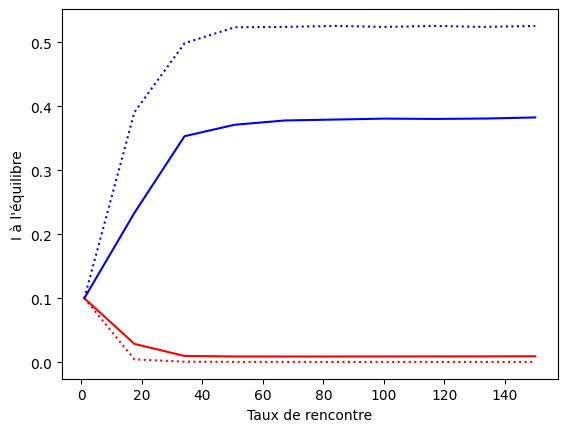

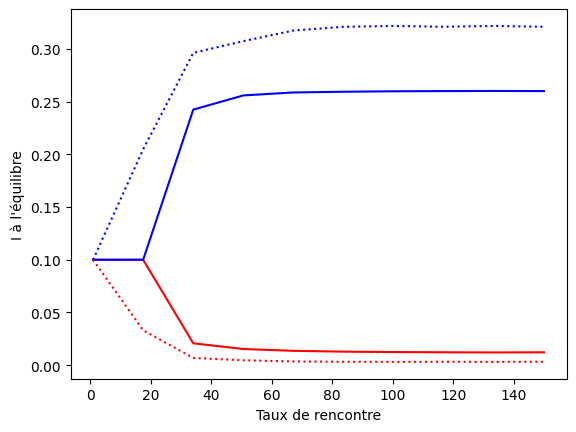

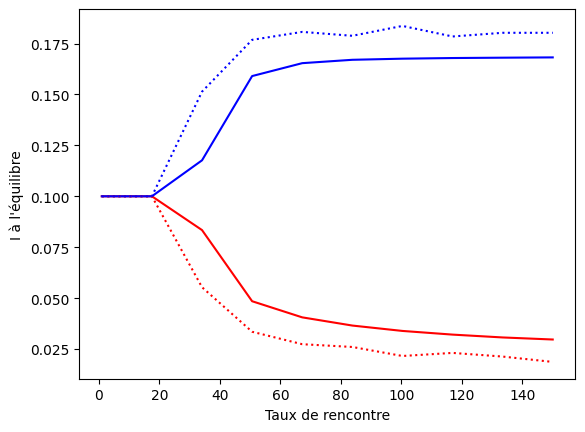

In [8]:
p2_vec = np.linspace(0.5, 2.5,3)
#3,0.5
#11.5,3
for compteur in range(len(p2_vec)):
    


    tmax =500
    pas = 5000
    nbr_pas = int(tmax/pas)
    temps = np.linspace(0,tmax,pas)

    #Paramètres démographiques
    B = 1
    x = 0.1
    c = 0.00
    d =  1

    #Paramètres épi
    var = 1
    gamma0 = 0.1
    vit1 = 50
    kappa = 0.1
    p1 =  11.5
    p2 = p2_vec[compteur]

    #Ci initiales
    S0 = 0.9
    I0 = 0.1
    vir0 = 1.44
    x0 = 0.5


    #kappa et vit comp devient un vec
    # lim_bas = [0.4,0.35,0.3,0.3,0.25,0.2,0.2,0.2,0.2,0.1]
    # lim_haut = lim_bas + np.repeat(0.15,10)
    tab_par1 = np.linspace(1, 150,10)
    #tab_par1 = np.linspace(0.001, 100,1000)

    tabeq_haut_1 =np.zeros_like(tab_par1)
    tabeq_bas_1 =np.zeros_like(tab_par1)

    tabeq_haut_2 =np.zeros_like(tab_par1)
    tabeq_bas_2 =np.zeros_like(tab_par1)

    for i in range(len(tab_par1)):
        #vit1=tab_par1[i]
        vit1 = tab_par1[i]
        sol = odeint(mod_vac_simp_comp, y0 = [S0,I0,vir0,x0], t=temps,args = (B, x , c, d, var, gamma0,vit1,kappa,p1,p2))
        smin=min(sol[pas-100:pas-1,1])
        smax=max(sol[pas-100:pas-1,1])

        tabeq_haut_1[i] = smin
        tabeq_bas_1[i] = smax


        vir= np.mean(sol[pas-100:pas-1,2])
        #txtrans=(p1*vir**p2)
        txtrans = (vir*p1)/(vir+p2) 
        sol2 = odeint(mod_vac_simp_comp_noevo, y0 = [S0,I0,x0], t=temps,args = (B,  c, d, vir,vit1,kappa,txtrans))
        smin2=min(sol2[pas-100:pas-1,1])
        smax2=max(sol2[pas-100:pas-1,1])


        tabeq_haut_2[i] = smin2
        tabeq_bas_2[i] = smax2


    figtrade, ax1 = plt.subplots()
    ax1.plot(tab_par1,tabeq_haut_1,color ="red")
    ax1.plot(tab_par1,tabeq_bas_1,color ="blue")
    ax1.plot(tab_par1,tabeq_haut_2,color ="red",linestyle="dotted")
    ax1.plot(tab_par1,tabeq_bas_2,color ="blue",linestyle="dotted")
    ax1.set_xlabel('Taux de rencontre')
    ax1.set_ylabel('I à l\'équilibre')
    plt.show()


## déséquilibre démographique

In [ ]:
p2_vec = np.linspace(0.1, 2.5,3)
#3,0.5
#11.5,3
for compteur in range(len(p2_vec)):
    
    p2 = 0.5

    tmax =500
    pas = 5000
    nbr_pas = int(tmax/pas)
    temps = np.linspace(0,tmax,pas)

    #Paramètres démographiques
    B = 1
    x = 0.1
    c = 0.00
    d =  p2_vec[compteur]

    #Paramètres épi
    var = 1
    gamma0 = 0.1
    vit1 = 50
    kappa = 0.1
    p1 =  11.5
    p2 = 1.5

    #Ci initiales
    S0 = 0.9
    I0 = 0.1
    vir0 = 1.44
    x0 = 0.5


    #kappa et vit comp devient un vec
    # lim_bas = [0.4,0.35,0.3,0.3,0.25,0.2,0.2,0.2,0.2,0.1]
    # lim_haut = lim_bas + np.repeat(0.15,10)
    tab_par1 = np.linspace(0.1, 2.5,2000)
    #tab_par1 = np.linspace(0.001, 100,1000)

    tabeq_haut_1 =np.zeros_like(tab_par1)
    tabeq_bas_1 =np.zeros_like(tab_par1)

    tabeq_haut_2 =np.zeros_like(tab_par1)
    tabeq_bas_2 =np.zeros_like(tab_par1)

    for i in range(len(tab_par1)):
        #vit1=tab_par1[i]
        B = tab_par1[i]
        sol = odeint(mod_vac_simp_comp, y0 = [S0,I0,vir0,x0], t=temps,args = (B, x , c, d, var, gamma0,vit1,kappa,p1,p2))
        smin=min(sol[pas-100:pas-1,1])
        smax=max(sol[pas-100:pas-1,1])

        tabeq_haut_1[i] = smin
        tabeq_bas_1[i] = smax


        vir= np.mean(sol[pas-100:pas-1,2])
        #txtrans=(p1*vir**p2)
        txtrans = (vir*p1)/(vir+p2) 
        sol2 = odeint(mod_vac_simp_comp_noevo, y0 = [S0,I0,x0], t=temps,args = (B,  c, d, vir,vit1,kappa,txtrans))
        smin2=min(sol2[pas-100:pas-1,1])
        smax2=max(sol2[pas-100:pas-1,1])


        tabeq_haut_2[i] = smin2
        tabeq_bas_2[i] = smax2


    figtrade, ax1 = plt.subplots()
    ax1.plot(tab_par1,tabeq_haut_1,color ="red")
    ax1.plot(tab_par1,tabeq_bas_1,color ="blue")
    ax1.plot(tab_par1,tabeq_haut_2,color ="red",linestyle="dotted")
    ax1.plot(tab_par1,tabeq_bas_2,color ="blue",linestyle="dotted")
    ax1.set_xlabel('Taux de naissance')
    ax1.set_ylabel('I à l\'équilibre')
    plt.show()


In [ ]:
p2_vec = np.linspace(1, 200,5)
#3,0.5
#11.5,3
for compteur in range(len(p2_vec)):
    
    p2 = 0.5

    tmax =500
    pas = 5000
    nbr_pas = int(tmax/pas)
    temps = np.linspace(0,tmax,pas)

    #Paramètres démographiques
    B = 1
    x = 0.1
    c = 0.00
    d =  1

    #Paramètres épi
    var = 1
    gamma0 = 0.1
    vit1 = p2_vec[compteur]
    kappa = 0.1
    p1 =  11.5
    p2 = 1.5

    #Ci initiales
    S0 = 0.9
    I0 = 0.1
    vir0 = 1.44
    x0 = 0.5


    #kappa et vit comp devient un vec
    # lim_bas = [0.4,0.35,0.3,0.3,0.25,0.2,0.2,0.2,0.2,0.1]
    # lim_haut = lim_bas + np.repeat(0.15,10)
    tab_par1 = np.linspace(1, 150,2000)
    #tab_par1 = np.linspace(0.001, 100,1000)

    tabeq_haut_1 =np.zeros_like(tab_par1)
    tabeq_bas_1 =np.zeros_like(tab_par1)

    tabeq_haut_2 =np.zeros_like(tab_par1)
    tabeq_bas_2 =np.zeros_like(tab_par1)

    for i in range(len(tab_par1)):
        #vit1=tab_par1[i]
        kappa = tab_par1[i]
        sol = odeint(mod_vac_simp_comp, y0 = [S0,I0,vir0,x0], t=temps,args = (B, x , c, d, var, gamma0,vit1,kappa,p1,p2))
        smin=min(sol[pas-100:pas-1,1])
        smax=max(sol[pas-100:pas-1,1])

        tabeq_haut_1[i] = smin
        tabeq_bas_1[i] = smax


        vir= np.mean(sol[pas-100:pas-1,2])
        #txtrans=(p1*vir**p2)
        txtrans = (vir*p1)/(vir+p2) 
        sol2 = odeint(mod_vac_simp_comp_noevo, y0 = [S0,I0,x0], t=temps,args = (B,  c, d, vir,vit1,kappa,txtrans))
        smin2=min(sol2[pas-100:pas-1,1])
        smax2=max(sol2[pas-100:pas-1,1])


        tabeq_haut_2[i] = smin2
        tabeq_bas_2[i] = smax2


    figtrade, ax1 = plt.subplots()
    ax1.plot(tab_par1,tabeq_haut_1,color ="red")
    ax1.plot(tab_par1,tabeq_bas_1,color ="blue")
    ax1.plot(tab_par1,tabeq_haut_2,color ="red",linestyle="dotted")
    ax1.plot(tab_par1,tabeq_bas_2,color ="blue",linestyle="dotted")
    ax1.set_xlabel('Taux de rencontre')
    ax1.set_ylabel('I à l\'équilibre')
    plt.show()


In [ ]:
figtrade, ax1 = plt.subplots()
ax1.scatter(tab_par1,tabeq_haut_1,color ="red")
ax1.scatter(tab_par1,tabeq_bas_1,color ="blue")
ax1.scatter(tab_par1,tabeq_haut_2,color ="orange",linestyle="dotted")
ax1.scatter(tab_par1,tabeq_bas_2,color ="purple",linestyle="dotted")
ax1.set_xlabel('Taux de rencontre')
ax1.set_ylabel('I à l\'équilibre')
ax1.set_ylim(0,0.5)

### Diagramme de bifurcation à deux paramètres

In [ ]:
tmax =100
pas = 1000

temps = np.linspace(0,tmax,pas)

#Paramètres démographiques
B = 1
x = 0.1
c = 0.00
d =  1

#Paramètres épi
var = 10
gamma0 = 0.1

p1 =  11.5
p2 = 0.5

#Ci initiales
S0 = 0.9
I0 = 0.1
vir0 = 1.44
x0 = 0.5

param_max =100

#on découpe les param d'interet en vecteur

par1 = np.linspace(1,100,param_max)
par2 = np.linspace(0.01,1,param_max)

#On crée un mlieu destockage de nos resultats
#cas sans comp
tabeq_haut_avec =np.zeros(shape=[param_max,param_max])
tabeq_bas_avec =np.zeros(shape=[param_max,param_max])
#cas avec
tabeq_haut_sans =np.zeros(shape=[param_max,param_max])
tabeq_bas_sans =np.zeros(shape=[param_max,param_max])

#Tab de stockage des res
tab_res_avec =np.zeros_like(tabeq_haut_avec)
tab_res_sans =np.zeros_like(tabeq_haut_sans)

for i in range(len(par1)):
    for y in range(len(par2)):
    #vit1=tab_par1[i]
        kappa = par2[y]
        vit1 = par1[i]
        # print(kappa,vit1)
        sol = odeint(mod_vac_simp_comp, y0 = [S0,I0,vir0,x0], t=temps,args = (B, x , c, d, var, gamma0,vit1,kappa,p1,p2))
        smin=min(sol[pas-100:pas-1,0])
        smax=max(sol[pas-100:pas-1,0])

        # tabeq_haut_avec[i,y] = smin
        # tabeq_bas_avec[i,y] = smax


        # vir= np.mean(sol[pas-100:pas-1,2])
        # #txtrans=(p1*vir**p2)
        # txtrans = (vir*p1)/(vir+p2) 
        # sol2 = odeint(mod_vac_simp_comp_noevo, y0 = [S0,I0,x0], t=temps,args = (B,  c, d, vir,vit1,kappa,txtrans))
        # smin2=min(sol2[pas-100:pas-1,0])
        # smax2=max(sol2[pas-100:pas-1,0])

        # tabeq_haut_sans[i,y] = smin2
        # tabeq_bas_sans[i,y] = smax2
        #Tableau res
        if smax - smin < 0.001:
            tab_res_avec[i,y] = 0
        else:
            tab_res_avec[i,y] = 1
            
        # if smax2 - smin2 <0.001:
        #     tab_res_sans[i,y] = 0
        # else:
        #     tab_res_sans[i,y] = 1
        
        # print(smax - smin )
        # sns.lineplot(x = temps, y = sol[:,0],color = "green").set(title = "Séries temporelles des sains (vert), infectés (rouge) et des coopérateurs (bleu)",xlabel="Temps")
        # sns.lineplot(x = temps, y = sol[:,1],color = "red")
        # sns.lineplot(x = temps, y = sol[:,3],color = "blue")
        # plt.show()

In [ ]:
#tab_res_avec[50,50] = 1

# make data
X, Y = np.meshgrid(par1, par2)

# # plot
# fig, ax = plt.subplots()

# ax.imshow(tab_res_avec, origin='lower')

# plt.show()

fig, ax = plt.subplots()

ax.pcolormesh(Y, X, tab_res_avec, vmin=-0.5, vmax=1.0)
ax.set_xlabel('Coût de la coopération')
ax.set_ylabel('Taux de rencontre')
plt.show()



fig, ax = plt.subplots()

ax.pcolormesh(Y, X, tab_res_sans, vmin=-0.5, vmax=1.0)

plt.show()



# Modele epi evo comp complet

In [15]:
# Modele evolution de la virulence et variance 
def mod_vac_full(init,t, B, x , c, d, gamma0,p1,p2,rhom):

    S =init[0]
    I =init[1]
    vir =init[2]
    var = init[3]
    

    Sprime = B*(1-x) - d *S + c *I - transmission(vir,p1,p2) * S *I
    Iprime = transmission(vir,p1,p2) * S *I - (d + c + vir)*I
    Virprime = var *(transmission2(vir,p1,p2) * (S + gamma0 * I) - 1 ) 
    Varprime = var**2 *(transmission3(vir,p1,p2)*(S + I*gamma0) ) + rhom

    return(Sprime,Iprime,Virprime,Varprime)

# Modele evolution de la virulence et variance 
def mod_vac_full_full(init,t, B, x , c, d, gamma0,vit1,kappa,p1,p2,rhom):

    S =init[0]
    I =init[1]
    virbar =init[2]
    var = init[3]
    vir = virbar -(p2/2)*var

    Sprime = B*(1-x) - d *S + c *I - transmission(vir,p1,p2) * S *I
    Iprime = transmission(vir,p1,p2) * S *I - (d + c + virbar)*I
    Virprime = var *(transmission2(vir,p1,p2) * (S + gamma0 * I) - 1 ) 
    Varprime = var**2 *(transmission3(vir,p1,p2)*(S + I*gamma0)) + rhom

    return(Sprime,Iprime,Virprime,Varprime)



def dens_norm(bins,mu, sigma):
    return(    1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2) )   )

### Modèle sans comportement

##### Paramètres

In [16]:
#Paramètres temps
tmax =200
pas = 1000
nbr_pas = int(tmax/pas)
temps = np.linspace(0,tmax,pas)

#Paramètres démographiques
B = 10
x = 0.35
c = 1
d =  0.1

#Paramètres épi
var = 100
gamma0 = 0.1
p1 =    2
p2 = 0.5
rhom = 0.01

#COmportement
vit1 = 1
kappa = 0.1
kappa2 = 0.9

#Ci initiales
S0 = 100
I0 = 1
vir0 = 0.2
x0 = 1



In [ ]:
#Simulation
sol_full = odeint(mod_vac_full, y0 = [S0,I0,vir0,x0], t=temps,args = (B, x , c, d, gamma0,p1,p2,rhom))
#Plot
sns.lineplot(x = temps, y = sol_full[:,2],color = "purple")
plt.show()
sns.lineplot(x = temps, y = sol_full[:,3],color = "purple")

### Plot 3d

In [ ]:
#Vecteur du temps / virulence
temps = np.linspace(0.1,tmax,pas)
vir_vecteur = np.linspace(0.01,5,1000)

#Grille
T_grid, Y_grid = np.meshgrid(temps,vir_vecteur)

# Densité proba de la virulence
Z = np.zeros_like(T_grid)
for i in range(len(temps)):
    vir_moy = sol_full[i,2]
    var_moy = sol_full[i,3]
    Z[:,i] = norm.pdf(vir_vecteur,vir_moy,var_moy)

# Graphique 
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

fig = go.Figure(data=[go.Surface(x=T_grid, y=Y_grid, z=Z, colorscale='Viridis')])

# Ajout de titres
fig.update_layout(scene=dict(
                    xaxis_title='Temps',
                    yaxis_title='Virulence',
                    zaxis_title='Densité de probabilité q(y)'),
                  title="Densité de probabilité de q(y) au fil du temps")

fig.show()

### Modèle avec comportement

In [19]:
#Definition du modèle
def mod_vac_full_comp(init,t, B, c, d, gamma0,vit1,kappa,p1,p2,rhom):

    S =init[0]
    I =init[1]
    comp = init[2]
    vir =init[3]
    var = init[4]
    
    

    Sprime = B*(1-comp) - d *S + c *I - beta(vir,p1,p2) * S *I
    Iprime = beta(vir,p1,p2) * S *I - (d + c + vir)*I
    Comprime = vit1 * comp*(1 - comp) *(I/(S+I) - kappa)
    Virprime = var *(beta2(vir,p1,p2) * (S + gamma0 * I) - 1 ) 
    Varprime = var ** 2 *(beta3(vir,p1,p2)*(S + I*gamma0) ) + rhom
    

    return(Sprime,Iprime,Comprime,Virprime,Varprime)

def mod_vac_full_comp2(init,t, B, c, d, gamma0,vit1,kappa,p1,p2,rhom):

    S =init[0]
    I =init[1]
    comp = init[2]
    vir =init[3]
    var = init[4]
    
    vir1 = vir - var * 1/2 

    
    

    Sprime = B*(1-comp) - d *S + c *I - beta(vir1,p1,p2) * S *I
    Iprime = beta(vir1,p1,p2) * S *I - (d + c + vir1)*I
    Comprime = vit1 * comp*(1 - comp) *(I/(S+I) - kappa)
    Virprime = var *(beta2(vir1,p1,p2) * (S + gamma0 * I) - 1 ) 
    Varprime = var ** 2 *(beta3(vir1,p1,p2)*(S + I*gamma0) ) + rhom
    

    return(Sprime,Iprime,Comprime,Virprime,Varprime)

In [ ]:

#Paramètres temps
tmax =500
pas = 1000
nbr_pas = int(tmax/pas)
temps = np.linspace(0,tmax,pas)






# #Paramètres démographiques
# B = 10
# c = 0.1
# d =  0.1

# #Paramètres épi
# gamma0 = 0.1
# p1 =    3
# p2 = 1


# #COmportement
# vit1 = 2.5
# kappa = 0.5

# #Ci initiales
# S0 = 10
# I0 = 1
# x0 = 0.1
# vir0 = 1





#Paramètres démographiques
B = 1

c = 0.01
d =  1

#Paramètres épi
var = 0.1
gamma0 = 0.1
vit1 = 100
kappa = 0.1
p1 =    9
p2 = 2

#Ci initiales
S0 = 0.9
I0 = 0.1
vir0 = 1
x0 = 0.5
var0 = 0.1

rhom = 0.05

sol_full_comp = odeint(mod_vac_full_comp2, y0 = [S0,I0,x0,vir0,var0], t=temps,args = (B, c, d, gamma0,vit1,kappa,p1,p2,rhom))

sns.lineplot(x = temps, y = sol_full_comp[:,2],color = "blue").set(title = "Dynamique des coopérateurs",xlabel="Temps",ylabel = "fraction coop")


In [ ]:
sns.lineplot(x = temps, y = sol_full_comp[:,0],color = "green").set(title = "Séries temporelles des sains (vert) et des infectés (rouge)",xlabel="Temps")
sns.lineplot(x = temps, y = sol_full_comp[:,1],color = "red")

In [ ]:
ax = sns.lineplot(x = temps, y = sol_full_comp[:,3],color = "purple").set(title = "Evolution de la virulence moyenne et de la variance génétique (pointillé)",xlabel="Temps")
ax = sns.lineplot(x = temps, y = sol_full_comp[:,4],color = "purple")
ax.lines[1].set_linestyle("--")
plt.show()

In [ ]:



temps = np.linspace(0.1,tmax,pas)
vir_vecteur = np.linspace(0.01,5,1000)





T_grid, Y_grid = np.meshgrid(temps,vir_vecteur)

Z = np.zeros_like(T_grid)

for i in range(len(temps)):
    vir_moy = sol_full_comp[i,2]
    var_moy = sol_full_comp[i,3]
    Z[:,i] = norm.pdf(vir_vecteur,vir_moy,var_moy)


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')




# Utilisation de T_grid, Y_grid et Z pour afficher le plot
# ax.plot_surface(T_grid, Y_grid, Z, cmap='viridis')

# ax.set_xlabel('Temps')
# ax.set_ylabel('Variable Y')
# ax.set_zlabel('Densité de probabilité q(y)')
# ax.set_title("Densité de probabilité de q(y) au fil du temps")

# plt.show()


fig = go.Figure(data=go.Surface(x=T_grid, y=Y_grid, z=Z, colorscale='Viridis'))

# Ajout de titres
fig.update_layout(scene=dict(
                    xaxis_title='Temps',
                    yaxis_title='Virulence'),
                   title="Densité de probabilité de q(y) au fil du temps")

fig.show()

In [24]:



# temps = np.linspace(0.1,tmax,pas)
# vir_vecteur = np.linspace(0.01,5,1000)





# T_grid, Y_grid = np.meshgrid(temps,vir_vecteur)

# Z = np.zeros_like(T_grid)

# for i in range(len(temps)):
#     vir_moy = sol_full_comp[i,2]
#     var_moy = sol_full_comp[i,3]
#     Z[:,i] = norm.pdf(vir_vecteur,vir_moy,var_moy)


# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')




# # Utilisation de T_grid, Y_grid et Z pour afficher le plot
# # ax.plot_surface(T_grid, Y_grid, Z, cmap='viridis')

# # ax.set_xlabel('Temps')
# # ax.set_ylabel('Variable Y')
# # ax.set_zlabel('Densité de probabilité q(y)')
# # ax.set_title("Densité de probabilité de q(y) au fil du temps")

# # plt.show()


# fig = go.Figure(data=go.Surface(x=T_grid, y=Y_grid, z=Z, colorscale='Viridis'))

# # Ajout de titres
# fig.update_layout(scene=dict(
#                     xaxis_title='Temps',
#                     yaxis_title='Virulence'),
#                    title="Densité de probabilité de q(y) au fil du temps")

# fig.show()

## Modele de bauch

In [ ]:
tmax = 365 * 50 * 10
pas = tmax

temps = np.linspace(0,tmax,pas)

#Paramètres démographiques
mu = 1/18250

gamma = 1/10
beta =10*(gamma + mu)
omega = 6000
kappa = 0.0005


#Ci initiales
S0 = 0.9
I0 = 0.1
x0 = 0.5
#Simulation du modèle


# Cas 2 comportement sans cycles mais coop


sol = odeint(mod_bauch,y0 = [S0,I0,x0],t =temps , args = (mu,beta,gamma,omega,kappa),atol= 1e-12, rtol =1e-12)

sns.lineplot(x = temps, y = sol[:,0],color = "green")
sns.lineplot(x = temps, y = sol[:,0],color = "red")
sns.lineplot(x = temps, y = sol[:,0],color = "black")
plt.show()


## Diagramme de bifurcation à deux param

In [58]:
def mod_bauch(t,init, mu,beta,gamma,omega,kappa):
    S,I,X = init


    Sprime = mu*(1 - x) - beta*S * I -mu*S
    Iprime = beta * S * I -gamma * I - mu*I
    Xprime = kappa*omega* x *(1 -x) *(  omega*I -1)

    return(Sprime,Iprime,Xprime)

In [ ]:
tmax = 365 * 50 * 10
pas = tmax
t_span = (0,tmax)
temps = np.linspace(0,tmax,pas)

#Paramètres démographiques
mu = 1/18250
gamma = 1/10
beta =10*(gamma + mu)
omega = 6000
kappa = 0.0005


#Ci initiales
S0 = 0.9
I0 = 0.1
x0 = 0.5
y0 = [S0,I0,x0]
#Simulation du modèle
param_max = 10

#on découpe les param d'interet en vecteur

par1 = np.linspace(1000,6000,param_max)
par2 = np.linspace(0.0001,0.002,param_max)

#On crée un mlieu destockage de nos resultats
#cas sans comp
tabeq_haut_avec =np.zeros(shape=[param_max,param_max])
tabeq_bas_avec =np.zeros(shape=[param_max,param_max])


#Tab de stockage des res
tab_res_avec =np.zeros_like(tabeq_haut_avec)

for i in range(len(par1)):
    for y in range(len(par2)):
    #vit1=tab_par1[i]
        omega = par2[y]
        kappa = par1[i]
        # print(kappa,vit1)
        param1 = mu,beta,gamma,omega,kappa
        sol = solve_ivp(mod_bauch,t_span,y0 , args = param1 ,atol= 1e-12, rtol =1e-12,max_step = 0.1, method = "LSODA")
        pas = sol.t.shape[0]
        smin=min(sol.y[0,pas-100:pas-1])
        smax=max(sol.y[0,pas-100:pas-1])

        # tabeq_haut_avec[i,y] = smin
        # tabeq_bas_avec[i,y] = smax


        # vir= np.mean(sol[pas-100:pas-1,2])
        # #txtrans=(p1*vir**p2)
        # txtrans = (vir*p1)/(vir+p2) 
        # sol2 = odeint(mod_vac_simp_comp_noevo, y0 = [S0,I0,x0], t=temps,args = (B,  c, d, vir,vit1,kappa,txtrans))
        # smin2=min(sol2[pas-100:pas-1,0])
        # smax2=max(sol2[pas-100:pas-1,0])

        # tabeq_haut_sans[i,y] = smin2
        # tabeq_bas_sans[i,y] = smax2
        #Tableau res

        if sol.y[2,pas-1] <0.0001:
            tab_res_avec[i,y] = 0
        elif smin - max <0.0001:
            tab_res_avec[i,y] = 1
        else:
            tab_res_avec[i,y] = 1

            
        # if smax2 - smin2 <0.001:
        #     tab_res_sans[i,y] = 0
        # else:
        #     tab_res_sans[i,y] = 1
        
        # print(smax - smin )
        # sns.lineplot(x = temps, y = sol[:,0],color = "green").set(title = "Séries temporelles des sains (vert), infectés (rouge) et des coopérateurs (bleu)",xlabel="Temps")
        # sns.lineplot(x = temps, y = sol[:,1],color = "red")
        # sns.lineplot(x = temps, y = sol[:,3],color = "blue")

        # plt.show()
        sns.lineplot(x = sol.t, y = sol.y[0,:],color = "green")
        sns.lineplot(x = sol.t, y = sol.y[1,:],color = "red")
        sns.lineplot(x = sol.t, y = sol.y[2,:],color = "black")
        plt.show()

In [ ]:
sol = solve_ivp(mod_bauch,t_span,y0 , args = param1 ,atol= 1e-12, rtol =1e-12)
sol.y[0,:]

In [ ]:
#tab_res_avec[50,50] = 1

# make data
X, Y = np.meshgrid(par1, par2)

# # plot
# fig, ax = plt.subplots()

# ax.imshow(tab_res_avec, origin='lower')

# plt.show()

fig, ax = plt.subplots()

ax.pcolormesh(Y, X, tab_res_avec, vmin=-0.5, vmax=1.0)
ax.set_xlabel('Coût de la coopération')
ax.set_ylabel('Taux de rencontre')
plt.show()


